# Sequence-to-sequence with CTC

In [1]:
import regex as re

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
%matplotlib inline

## Load train set

In [3]:
# Load train set
df = pd.read_csv("../scratch/train.tsv", sep="\t", na_filter=False, encoding="utf-8")
df.head()

text      pronunciation
0           anatines           a.na.tin
1  omniscientisasses  ɔm.ni.sjɑ̃.ti.zas
2        re-répétera     ʁə.ʁe.pɛ.tə.ʁa
3      recaracoleras  ʁə.ka.ʁa.kɔ.lə.ʁa
4   désinformeraient   de.zɛ̃.fɔʁ.mə.ʁɛ

In [4]:
# Use lowercase text
df["text"] = df["text"].str.lower()

# Discard syllable information
df["pronunciation"] = df["pronunciation"].str.replace(".", "").str.replace("‿", " ")

In [5]:
# Compute length ratio
df["ratio"] = df["text"].apply(len) / df["pronunciation"].apply(len)

# Discard small ratio (typically abbreviations) and large ratios (often incomplete IPA)
t_df = df[(df["ratio"] > 0.8) & (df["ratio"] < 4.0)]

## Create vocabularies

In [6]:
# For text, we just look at characters, as-is
def tokenize_text(text):
    return list(text)

# For pronunciation, we need to attach the tilde surrogates properly
def tokenize_pronunciation(pronunciation):
    match = re.fullmatch(r"(.\u0303?)*", pronunciation)
    return match.captures(1)

In [7]:
# Tokenize the full dataset
tokenized_text = df["text"].apply(tokenize_text)
tokenized_pronunciation = df["pronunciation"].apply(tokenize_pronunciation)

In [8]:
class Vocabulary:
    def __init__(self, tokens):
        tokens = sorted(set(tokens))
        self.tokens = ["<PAD>", *tokens]
        self.token_map = {token: index + 1 for index, token in enumerate(tokens)}

    def __len__(self):
        return len(self.tokens)
        
    def encode(self, tokens):
        indices = [self.token_map[token] for token in tokens]
        # Note that no <PAD> is inserted at the end
        return torch.tensor(indices)
    
    def decode(self, indices):
        tokens = []
        for i in indices:
            if i == 0:
                break
            token = self.tokens[i]
            tokens.append(token)
        return tokens
    
    @classmethod
    def from_sequences(cls, sequences):
        tokens = set()
        for sequence in sequences:
            tokens.update(sequence)
        return cls(tokens)

In [9]:
# Create vocabularies, to vectorize sequences
text_vocabulary = Vocabulary.from_sequences(tokenized_text)
pronunciation_vocabulary = Vocabulary.from_sequences(tokenized_pronunciation)

## Create data loader

In [10]:
# Choose whether to use GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

In [11]:
# Prepare dataset
train_dataset = list(zip(
    map(text_vocabulary.encode, tokenized_text),
    map(pronunciation_vocabulary.encode, tokenized_pronunciation),
))

In [12]:
# Need special collate function to handle variable-length data
def collate(batch):
    inputs, outputs = zip(*batch)
    
    input_sequences = nn.utils.rnn.pad_sequence(inputs)
    output_sequences = nn.utils.rnn.pad_sequence(outputs)
    
    input_lengths = torch.tensor([len(i) for i in inputs], dtype=torch.long)
    output_lengths = torch.tensor([len(o) for o in outputs], dtype=torch.long)
    
    return input_sequences, input_lengths, output_sequences, output_lengths

# Wrap dataset into loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    collate_fn=collate,
    pin_memory=use_cuda,
)

## Define model

In [13]:
class Model(nn.Module):
    def __init__(self, num_input_symbols, num_output_symbols, embedding_size, hidden_size):
        super().__init__()
        
        # Store parameters
        self.num_input_symbols = num_input_symbols
        self.num_output_symbols = num_output_symbols
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        
        # Input symbols are embedded
        self.embedding = nn.Embedding(
            num_embeddings=num_input_symbols,
            embedding_dim=embedding_size,
            padding_idx=0,
        )
        
        # We will use a combination of regular convolutions and transposed convolutions
        # Note that we need some expansion, as CTC assumes that output lengths are smaller than input lengths
        self.c1 = nn.Conv1d(embedding_size, hidden_size, kernel_size=3, padding=1)
        self.c2 = nn.Conv1d(hidden_size, hidden_size * 2, kernel_size=3, padding=1)
        self.c3 = nn.ConvTranspose1d(hidden_size * 2, hidden_size * 3, kernel_size=3, stride=3)
        self.c4 = nn.Conv1d(hidden_size * 3, hidden_size * 4, kernel_size=3, padding=1)
        self.c5 = nn.Conv1d(hidden_size * 4, num_output_symbols, kernel_size=1)
    
    def forward(self, input_sequences, input_lengths):
        
        # First, embed symbols
        tmp = self.embedding(input_sequences)
        
        # Need to transpose, as
        #   rnn are length x batch_size x features
        #   convolution are batch_size x features x length
        tmp = tmp.permute(1, 2, 0)
        
        # Apply convolutions
        tmp = F.leaky_relu(self.c1(tmp))
        tmp = F.leaky_relu(self.c2(tmp))
        tmp = F.leaky_relu(self.c3(tmp))
        tmp = F.leaky_relu(self.c4(tmp))
        tmp = self.c5(tmp)
        
        # Restore dimension order
        output_sequences = tmp.permute(2, 0, 1)
        
        # Compute new length (hard-coded, depends on our convolutions)
        output_lengths = input_lengths * 3
        
        return output_sequences, output_lengths

## Do training

In [14]:
# Instanciate model
model = Model(
    num_input_symbols=len(text_vocabulary),
    num_output_symbols=len(pronunciation_vocabulary),
    embedding_size=16,
    hidden_size=64,
)
if use_cuda:
    model.cuda()

# Instanciate optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [15]:
# Train loop
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    for input_sequences, input_lengths, output_sequences, output_lengths in tqdm(train_loader):
        if use_cuda:
            input_sequences = input_sequences.cuda()
            input_lengths = input_lengths.cuda()
            output_sequences = output_sequences.cuda()
            output_lengths = output_lengths.cuda()
        
        # Apply model
        logits, lengths = model(input_sequences, input_lengths)
        log_probs = F.log_softmax(logits, dim=2)
        
        # Compute CTC loss
        loss = F.ctc_loss(
            log_probs=log_probs,
            targets=output_sequences.transpose(1, 0),
            input_lengths=lengths,
            target_lengths=output_lengths,
            zero_infinity=True,
        )
        loss_value = loss.item()
        assert not np.isnan(loss_value)
        losses.append(loss_value)
        
        # Back-propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

 41%|████████████████████████████████                                               | 991/2438 [00:12<00:18, 76.57it/s]


KeyboardInterrupt: 

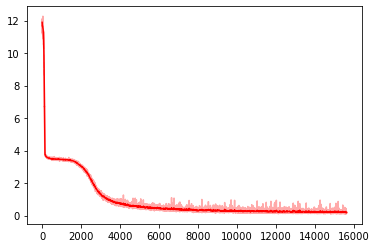

In [16]:
# Plot training loss
fig, ax = plt.subplots()

y = np.array(losses)
x = np.arange(y.shape[0])
y_smooth = gaussian_filter1d(y, 5, mode="nearest")

ax.plot(x, y, c="#ffaaaa")
ax.plot(x, y_smooth, "r")

plt.show()

In [17]:
# Save trained model for later
model.cpu()
torch.save(model.state_dict(), "ctc.pt")

## Apply to unseen input

In [18]:
# Switch to evaluation mode
model.eval()

Model(
  (embedding): Embedding(47, 16, padding_idx=0)
  (c1): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (c2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (c3): ConvTranspose1d(128, 192, kernel_size=(3,), stride=(3,))
  (c4): Conv1d(192, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (c5): Conv1d(256, 39, kernel_size=(1,), stride=(1,))
)

In [19]:
def translate(text):
    with torch.no_grad():

        # Convert graphemes to indices
        input_sequences = text_vocabulary.encode(text).unsqueeze(1)
        input_lengths = torch.tensor([input_sequences.shape[0]], dtype=torch.long)

        # Apply model
        logits, output_lengths = model(input_sequences, input_lengths)

        # Extract the raw indices (i.e. best path decoding)
        indices = logits.argmax(dim=2)
        length = output_lengths[0]
        indices = indices[:length, 0].tolist()

        # Deduplicate indices, as per CTC scheme
        output = []
        previous = None
        for index in indices:
            if index != previous:
                previous = index
                if index > 0:
                    output.append(index)

        # Convert back to IPA
        pronunciation = pronunciation_vocabulary.decode(output)
        pronunciation = "".join(pronunciation)
        return pronunciation

In [20]:
translate("terrible")

'tɛʁibl'

In [21]:
translate("anticonstitutionnellement")

'ɑ̃tikɔ̃stitysjɔnɛlmɑ̃'

In [22]:
translate("un chat")

'n ʃa'

In [23]:
translate("l'arbre qui cache la forêt")

'l aʁbʁ ki kaʃ la fɔʁɛ'

In [25]:
translate("les poules du couvent couvent le matin")

'l pul dy kuvɑ̃ kuvɑ̃ lə matɛ̃'

## Evaluate on test set

In [35]:
# TODO ...

## Show alignment

In [26]:
def translate_and_align(text):
    with torch.no_grad():

        # Convert graphemes to indices
        input_sequences = text_vocabulary.encode(text).unsqueeze(1)
        input_lengths = torch.tensor([input_sequences.shape[0]], dtype=torch.long)

        # Apply model
        logits, output_lengths = model(input_sequences, input_lengths)

        # Extract the raw indices
        indices = logits.argmax(dim=2)
        length = output_lengths[0]
        indices = indices[:length, 0].tolist()

        # Deduplicate indices, as per CTC scheme
        offsets = []
        output = []
        previous = None
        for offset, index in enumerate(indices):
            if index != previous:
                previous = index
                if index > 0:
                    # TODO should maybe consider middle offset, instead of the first one?
                    offsets.append(offset // 3)
                    output.append(index)

        # Convert back to IPA
        pronunciation = pronunciation_vocabulary.decode(output)
        
        return offsets, pronunciation

In [27]:
def show_translation_alignment(text):
    text = list(text)
    
    # Apply model to translate and get alignment
    offsets, pronunciation = translate_and_align(text)
    
    # Build alignment matrix
    matrix = np.zeros((len(offsets), len(text)))
    for o, i in enumerate(offsets):
        matrix[o, i] = 1

    # Inverse vertically
    matrix = matrix[::-1]
    pronunciation = pronunciation[::-1]

    # Show matrix, with labels
    fig, ax = plt.subplots()
    ax.imshow(matrix)
    plt.yticks(range(len(pronunciation)), pronunciation)
    plt.xticks(range(len(text)), text)
    plt.show()

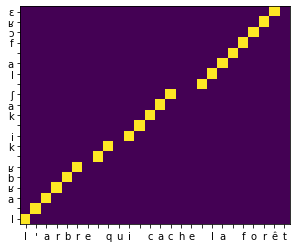

In [28]:
show_translation_alignment("l'arbre qui cache la forêt")

## Infer alignment from both input and output

In [ ]:
# Connectionist temporal classification: Labelling unsegmented sequence data with recurrent neural networks
#   https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/LossCTC.cpp
#   https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.75.6306

In [108]:
def align(text, pronunciation):
    
    # Make sure we have lists of tokens
    if isinstance(text, str):
        text = tokenize_text(text)
    if isinstance(pronunciation, str):
        pronunciation = tokenize_pronunciation(pronunciation)
    
    # Torch realm, ignore gradients
    with torch.no_grad():

        # Convert graphemes to indices
        input_sequences = text_vocabulary.encode(text).unsqueeze(1)
        input_lengths = torch.tensor([input_sequences.shape[0]], dtype=torch.long)

        # Apply model
        logits, lengths = model(input_sequences, input_lengths)
        log_probs = F.log_softmax(logits, dim=2)

        # Also get output
        output_sequence = pronunciation_vocabulary.encode(pronunciation)

    # Convert to numpy, for simplicity
    y = np.exp(log_probs.squeeze(1).numpy().astype(np.double))
    l = output_sequence.numpy().astype(int)

    # Insert blank symbols
    l_ = [0]
    for o in l:
        l_.append(o.item())
        l_.append(0)
    l_ = np.array(l_)
    
    # Get alignment dimensionality
    T = y.shape[0]
    S = l_.shape[0]
    
    # NOTE: for numerical stability, this should be done in log-space (as it is done in PyTorch)
    
    # Compute forward probabilities
    alphas = np.zeros((T, S))

    # Initialization, above eq. (6)
    alphas[0, 0] = y[0, 0]
    alphas[0, 1] = y[0, l[0]]

    # Recursion
    for t in range(1, T):
        for s in range(0, S):

            # eq. (7)
            if s < 1:
                alpha_ = alphas[t - 1, s]
            else:
                alpha_ = alphas[t - 1, s] + alphas[t, s - 1]

            # eq. (6)
            if l_[s] == 0 or s < 2 or l_[s - 2] == l_[s]:
                alphas[t, s] = alpha_ * y[t, l_[s]]
            else:
                alphas[t, s] = (alpha_ + alphas[t - 1, s - 2]) * y[t, l_[s]]
    
    # Compute backward probabilities
    betas = np.zeros((T, S))

    # Initialization, above eq. (10)
    betas[T - 1, S - 1] = y[T - 1, 0]
    betas[T - 1, S - 2] = y[T - 1, l[-1]]

    # Recursion
    for t in range(T - 2, -1, -1):
        for s in range(S - 1, -1, -1):

            # eq. (11)
            if s > S - 2:
                beta_ = betas[t + 1, s]
            else:
                beta_ = betas[t + 1, s] + betas[t + 1, s + 1]

            # eq. (10)
            if l_[s] == 0 or s > S - 3 or l_[s + 2] == l_[s]:
                betas[t, s] = beta_ * y[t, l_[s]]
            else:
                betas[t, s] = (beta_ + betas[t + 1, s + 2]) * y[t, l_[s]]
    
    # Product of alpha and beta is the probability of a path going through input timestep T and output timestep S
    p = alphas * betas
    return p

In [109]:
def show_alignment(text, pronunciation):
    
    # Make sure we have lists of tokens
    if isinstance(text, str):
        text = tokenize_text(text)
    if isinstance(pronunciation, str):
        pronunciation = tokenize_pronunciation(pronunciation)
    
    # Apply model and then compute alignment probabilities
    p = align(text, pronunciation)
    
    # Normalize rows, i.e. we can see distribution aver graphemes for each phoneme
    p = p / p.sum(axis=0)[None, :]
    
    # Show matrix, with labels
    fig, ax = plt.subplots()
    ax.imshow(p.T[::-1])
    plt.yticks(range(1, 2 * len(pronunciation), 2), pronunciation[::-1])
    plt.xticks(range(1, 3 * len(text), 3), text)
    plt.show()

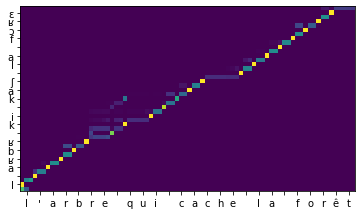

In [110]:
show_alignment(
    "l'arbre qui cache la forêt",
    "l aʁbʁ ki kaʃ la fɔʁɛ",
)

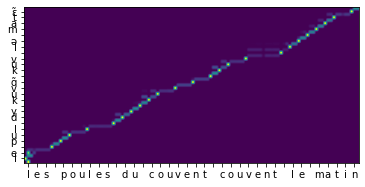

In [111]:
show_alignment(
    "les poules du couvent couvent le matin",
    "le pul dy kuvɑ̃ kuv lə matɛ̃",
)